# Imports

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import torchvision
from torchvision import transforms
from tqdm import tqdm
import math
import sys
import os
import matplotlib.pyplot as plt

In [4]:
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = '/content/drive/MyDrive/master/ml'
else:
    BASE_DIR = '.'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model code

In [42]:
import torch
from torch import nn
import torch.nn.functional as F
from collections import namedtuple

InceptionOutputs = namedtuple("InceptionOutputs", ["logits", "aux_logits"])

class ConvBlock(nn.Module):
    def __init__(self, in_dim, out_dim, kernel, padding, stride=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_dim,
                              out_channels=out_dim,
                              kernel_size=kernel,
                              padding=padding,
                              stride=stride,
                              bias=False)
        self.bn = nn.BatchNorm2d(num_features=out_dim, eps=.001)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.activation(x)


class InceptionA(nn.Module):
    def __init__(self, in_dim, pooling_dim, pooling_layer=nn.AvgPool2d):
        super(InceptionA, self).__init__()
        self.conv_1x1 = ConvBlock(in_dim=in_dim, out_dim=64, kernel=1, padding='same')

        self.conv_5x5_1 = ConvBlock(in_dim=in_dim, out_dim=48, kernel=1, padding='same')
        self.conv_5x5_2 = ConvBlock(in_dim=48, out_dim=64, kernel=5, padding='same')

        self.conv_5x5 = nn.Sequential(self.conv_5x5_1, self.conv_5x5_2)

        self.conv_3x3_1 = ConvBlock(in_dim=in_dim, out_dim=64, kernel=1, padding='same')
        self.conv_3x3_2 = ConvBlock(in_dim=64, out_dim=96, kernel=3, padding='same')
        self.conv_3x3_3 = ConvBlock(in_dim=96, out_dim=96, kernel=3, padding='same')

        self.conv_3x3 = nn.Sequential(self.conv_3x3_1, self.conv_3x3_2, self.conv_3x3_3)

        self.pool = nn.Sequential(
            pooling_layer(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_dim=in_dim, out_dim=pooling_dim, kernel=1, padding='same')
        )

    def forward(self, x):
        conv_1x1 = self.conv_1x1(x)

        conv_5x5 = self.conv_5x5(x)

        conv_3x3 = self.conv_3x3(x)

        pool = self.pool(x)

        out = [conv_1x1, conv_3x3, conv_5x5, pool]

        return torch.cat(out, dim=1)


class InceptionB(nn.Module):
    def __init__(self, in_dim, pooling=nn.MaxPool2d):
        super(InceptionB, self).__init__()

        self.conv_3x3 = ConvBlock(in_dim=in_dim, out_dim=384, kernel=3, stride=2, padding=0)

        self.conv_3x3dbl = nn.Sequential(
            ConvBlock(in_dim=in_dim, out_dim=64, kernel=1, padding='same'),
            ConvBlock(in_dim=64, out_dim=96, kernel=3, padding='same'),
            ConvBlock(in_dim=96, out_dim=96, kernel=3, stride=2, padding=0)
        )

        self.pool = pooling(kernel_size=3, stride=2)

    def forward(self, x):
        conv_3x3 = self.conv_3x3(x)

        conv_3x3dbl = self.conv_3x3dbl(x)

        pool = self.pool(x)

        out = [conv_3x3, conv_3x3dbl, pool]

        return torch.cat(out, dim=1)


class InceptionC(nn.Module):
    def __init__(self, in_dim, dim_7x7, pooling=nn.AvgPool2d):
        super(InceptionC, self).__init__()

        self.conv_1x1 = ConvBlock(in_dim=in_dim, out_dim=192, kernel=1, padding=0)

        self.conv_7x7 = nn.Sequential(
            ConvBlock(in_dim=in_dim, out_dim=dim_7x7, kernel=1, padding=0),
            ConvBlock(in_dim=dim_7x7, out_dim=dim_7x7, kernel=(1,7), padding=(0,3)),
            ConvBlock(in_dim=dim_7x7, out_dim=192, kernel=(7,1), padding=(3,0))
        )

        self.conv_7x7dbl = nn.Sequential(
            ConvBlock(in_dim=in_dim, out_dim=dim_7x7, kernel=1, padding=0),
            ConvBlock(in_dim=dim_7x7, out_dim=dim_7x7, kernel=(7,1), padding=(3,0)),
            ConvBlock(in_dim=dim_7x7, out_dim=dim_7x7, kernel=(1,7), padding=(0,3)),
            ConvBlock(in_dim=dim_7x7, out_dim=dim_7x7, kernel=(7,1), padding=(3,0)),
            ConvBlock(in_dim=dim_7x7, out_dim=192, kernel=(1,7), padding=(0,3))
        )

        self.pool = nn.Sequential(
            pooling(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_dim=in_dim, out_dim=192, kernel=1, padding=0)
        )

    def forward(self, x):
        conv_1x1 = self.conv_1x1(x)

        conv_7x7 = self.conv_7x7(x)

        conv_7x7dbl = self.conv_7x7dbl(x)

        pool = self.pool(x)

        out = [conv_1x1, conv_7x7, conv_7x7dbl, pool]

        return torch.cat(out, dim=1)


class InceptionD(nn.Module):
    def __init__(self, in_dim, pooling=nn.MaxPool2d):
        super(InceptionD, self).__init__()

        self.conv_3x3 = nn.Sequential(
            ConvBlock(in_dim=in_dim, out_dim=192, kernel=1, padding=0),
            ConvBlock(in_dim=192, out_dim=320, kernel=3, stride=2, padding=0)
        )

        self.conv_7x7x3 = nn.Sequential(
            ConvBlock(in_dim=in_dim, out_dim=192, kernel=1, padding=0),
            ConvBlock(in_dim=192, out_dim=192, kernel=(1,7), padding=(0,3)),
            ConvBlock(in_dim=192, out_dim=192, kernel=(7,1), padding=(3,0)),
            ConvBlock(in_dim=192, out_dim=192, kernel=3, stride=2, padding=0),
        )

        self.pool = pooling(kernel_size=3, stride=2)

    def forward(self, x):
        conv_3x3 = self.conv_3x3(x)

        conv_7x7x3 = self.conv_7x7x3(x)

        pool = self.pool(x)

        out = [conv_3x3, conv_7x7x3, pool]

        return torch.cat(out, dim=1)


class InceptionE(nn.Module):
    def __init__(self, in_dim, pooling=nn.AvgPool2d):
        super(InceptionE, self).__init__()

        self.conv_1x1 = ConvBlock(in_dim=in_dim, out_dim=320, kernel=1, padding=0)

        self.conv_3x3 = ConvBlock(in_dim=in_dim, out_dim=384, kernel=1, padding=0)

        self.conv_3x3_a = ConvBlock(in_dim=384, out_dim=384, kernel=(1,3), padding=(0,1))
        self.conv_3x3_b = ConvBlock(in_dim=384, out_dim=384, kernel=(3,1), padding=(1,0))

        self.conv_3x3dbl = nn.Sequential(
            ConvBlock(in_dim=in_dim, out_dim=448, kernel=1, padding=0),
            ConvBlock(in_dim=448, out_dim=384, kernel=3, padding=1),
        )
        self.conv_3x3dbl_a = ConvBlock(in_dim=384, out_dim=384, kernel=(1,3), padding=(0,1))
        self.conv_3x3dbl_b = ConvBlock(in_dim=384, out_dim=384, kernel=(3,1), padding=(1,0))

        self.pool = nn.Sequential(
            pooling(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_dim=in_dim, out_dim=192, kernel=1, padding=0)
        )

    def forward(self, x):
        conv_1x1 = self.conv_1x1(x)

        conv_3x3 = self.conv_3x3(x)
        conv_3x3 = torch.cat([self.conv_3x3_a(conv_3x3), self.conv_3x3_b(conv_3x3)], dim=1)

        conv_3x3dbl = self.conv_3x3dbl(x)
        conv_3x3dbl = torch.cat([self.conv_3x3dbl_a(conv_3x3dbl), self.conv_3x3dbl_b(conv_3x3dbl)], dim=1)

        pool = self.pool(x)

        out = [conv_1x1, conv_3x3, conv_3x3dbl, pool]

        return torch.cat(out, dim=1)


class InceptionAux(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(InceptionAux, self).__init__()

        self.conv0 = ConvBlock(in_dim=in_dim, out_dim=128, kernel=1, padding=0)
        self.conv1 = ConvBlock(in_dim=128, out_dim=768, kernel=5, padding=0)

        self.conv1.stddev = torch.tensor(.01)

        self.fc = nn.Linear(768, out_dim)
        self.fc.stddev = torch.tensor(.001)

    def forward(self, x):
        # x = F.avg_pool2d(x, kernel_size=5, stride=3)

        x = self.conv0(x)

        x = self.conv1(x)

        x = F.adaptive_avg_pool2d(x, output_size=(1,1))

        x = x.view(x.size(0), -1)

        return self.fc(x)


class InceptionV3(nn.Module):
    def __init__(self, out_dim, aux_logits):
        super(InceptionV3, self).__init__()

        self.aux_logits = aux_logits
        
        self.conv0 = ConvBlock(3, 192, kernel=3, padding=1)

        self.mixed_5b = InceptionA(192, 32)
        self.mixed_5c = InceptionA(256, 64)
        self.mixed_5d = InceptionA(288, 64)

        self.mixed_6a = InceptionB(288)
        self.mixed_6b = InceptionC(768, 128)
        self.mixed_6c = InceptionC(768, 160)
        self.mixed_6d = InceptionC(768, 160)
        self.mixed_6e = InceptionC(768, 192)

        if self.aux_logits:
            self.aux = InceptionAux(768, out_dim)

        self.mixed_7a = InceptionD(768)
        self.mixed_7b = InceptionE(1280)
        self.mixed_7c = InceptionE(2048)

        self.fc = nn.Linear(2048, out_dim)

    def forward(self, x):
        # 3 x 32 x 32
        x = self.conv0(x)

        # 192 x 32 x 32
        x = self.mixed_5b(x)

        # 256 x 32 x 32
        x = self.mixed_5c(x)

        # 288 x 32 x 32
        x = self.mixed_5d(x)
        
        # 288 x 32 x 32
        x = self.mixed_6a(x)

        # 768 x 15 x 15
        x = self.mixed_6b(x)

        # 768 x 15 x 15
        x = self.mixed_6c(x)
        
        x = self.mixed_6d(x)

        x = self.mixed_6e(x)

        if self.training and self.aux_logits:
            aux = self.aux(x)

        x = self.mixed_7a(x)

        x = self.mixed_7b(x)

        x = self.mixed_7c(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = F.dropout(x, training=self.training)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        # x = F.softmax(x)

        if self.training and self.aux_logits:
            return InceptionOutputs(x, aux)

        return x

# Import data

In [28]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

train_val_ds = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_ds, val_ds = torch.utils.data.random_split(train_val_ds, [.9, .1])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_ds = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# W/o aux

## Training loop

In [31]:
model = InceptionV3(10, False)

In [32]:
num_epochs = 15
file_label = 'inceptionv3-adam-15-cifar10'

model = model.to(DEVICE)

if os.path.exists(f'{BASE_DIR}/checkpoints/savepoint-{file_label}.pt'):
    model.load_state_dict(torch.load(f'{BASE_DIR}/checkpoints/savepoint-{file_label}.pt'))
    history = torch.load(f'{BASE_DIR}/checkpoints/history-{file_label}.pt')
else:
    history = {
        'loss': [],
        'val_loss': []
    }

num_epochs_completed = len(history['loss'])

criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epochs_completed, num_epochs+1):
    with tqdm(train_dl, unit='batch') as tepoch:
        epoch_losses = []
        model.train()
        for data, target in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            data, target = data.to(DEVICE), F.one_hot(target, 10).float().to(DEVICE)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            correct = (out.argmax(1) == target.argmax(1)).sum().item()
            accuracy = correct / len(target)

            tepoch.set_postfix(loss=loss.item(), accuracy=accuracy)
    epoch_mean_loss = sum(epoch_losses) / len(epoch_losses)
    history['loss'].append(epoch_mean_loss)

    with torch.no_grad():
        epoch_val_losses = []
        model.eval()
        for data, target in val_dl:
            data, target = data.to(DEVICE), F.one_hot(target, 10).float().to(DEVICE)
            out = model(data)
            loss = criterion(out, target)
            epoch_val_losses.append(loss.item())
        epoch_mean_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
        history['val_loss'].append(epoch_mean_val_loss)

    torch.save(model.state_dict(), f'{BASE_DIR}/checkpoints/savepoint-{file_label}.pt')
    torch.save(history, f'{BASE_DIR}/checkpoints/history-{file_label}.pt')

    print(f'done epoch {epoch} with results: loss={epoch_mean_loss}, val_loss={epoch_mean_val_loss}')

Epoch 0: 100%|██████████| 352/352 [00:43<00:00,  8.03batch/s, accuracy=0.542, loss=1.3]  


done epoch 0 with results: loss=1.4292087632824073, val_loss=1.5024701595306396


Epoch 1: 100%|██████████| 352/352 [00:43<00:00,  8.05batch/s, accuracy=0.764, loss=0.658]


done epoch 1 with results: loss=0.899137216704813, val_loss=0.8789776414632797


Epoch 2: 100%|██████████| 352/352 [00:43<00:00,  8.03batch/s, accuracy=0.819, loss=0.491]


done epoch 2 with results: loss=0.667005817829208, val_loss=0.73724794536829


Epoch 3: 100%|██████████| 352/352 [00:43<00:00,  8.03batch/s, accuracy=0.889, loss=0.38] 


done epoch 3 with results: loss=0.5308878623287786, val_loss=0.5212277621030807


Epoch 4: 100%|██████████| 352/352 [00:43<00:00,  8.03batch/s, accuracy=0.833, loss=0.529]


done epoch 4 with results: loss=0.4380797226489945, val_loss=0.532693962007761


Epoch 5: 100%|██████████| 352/352 [00:43<00:00,  8.02batch/s, accuracy=0.847, loss=0.413]


done epoch 5 with results: loss=0.3690239866687493, val_loss=0.47764636352658274


Epoch 6: 100%|██████████| 352/352 [00:43<00:00,  8.04batch/s, accuracy=0.778, loss=0.474]


done epoch 6 with results: loss=0.31218682551248506, val_loss=0.4757805556058884


Epoch 7: 100%|██████████| 352/352 [00:43<00:00,  8.03batch/s, accuracy=0.889, loss=0.228]


done epoch 7 with results: loss=0.2699455558110706, val_loss=0.539562176167965


Epoch 8: 100%|██████████| 352/352 [00:43<00:00,  8.04batch/s, accuracy=0.931, loss=0.182] 


done epoch 8 with results: loss=0.23021918702447278, val_loss=0.4896634977310896


Epoch 9: 100%|██████████| 352/352 [00:43<00:00,  8.04batch/s, accuracy=0.958, loss=0.133] 


done epoch 9 with results: loss=0.19601870448836548, val_loss=0.39725821018218993


Epoch 10: 100%|██████████| 352/352 [00:43<00:00,  8.04batch/s, accuracy=0.958, loss=0.108] 


done epoch 10 with results: loss=0.17028508896262132, val_loss=0.4424818783998489


Epoch 11: 100%|██████████| 352/352 [00:43<00:00,  8.03batch/s, accuracy=0.958, loss=0.132] 


done epoch 11 with results: loss=0.14501984472471205, val_loss=0.5527159076184034


Epoch 12: 100%|██████████| 352/352 [00:43<00:00,  8.04batch/s, accuracy=0.986, loss=0.077] 


done epoch 12 with results: loss=0.12233733529732986, val_loss=0.48301704227924347


Epoch 13: 100%|██████████| 352/352 [00:43<00:00,  8.04batch/s, accuracy=0.958, loss=0.144] 


done epoch 13 with results: loss=0.10879022809570994, val_loss=0.49227306097745893


Epoch 14: 100%|██████████| 352/352 [00:43<00:00,  8.02batch/s, accuracy=0.958, loss=0.128] 


done epoch 14 with results: loss=0.10153983464062383, val_loss=0.4251784052699804


Epoch 15: 100%|██████████| 352/352 [00:43<00:00,  8.05batch/s, accuracy=0.986, loss=0.0497]


done epoch 15 with results: loss=0.07908760984851555, val_loss=0.4667627077549696


## History

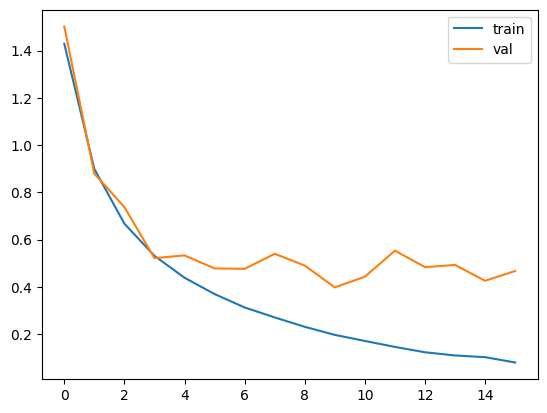

In [33]:
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')

plt.legend()

plt.show()

## Metrics

In [34]:
test_losses = []
test_acc = []
with torch.no_grad():
    model = model.eval()
    for data, label in test_dl:
        data, label = data.to(DEVICE), F.one_hot(label, 10).float().to(DEVICE)
        out = model(data)

        loss = criterion(out, label)
        test_losses.append(loss.item())

        correct = (out.argmax(1) == label.argmax(1)).sum().item()
        accuracy = correct / len(label)
        test_acc.append(accuracy)

sum(test_losses) / len(test_losses), sum(test_acc) / len(test_acc)

(0.5024242035195797, 0.8749011075949367)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


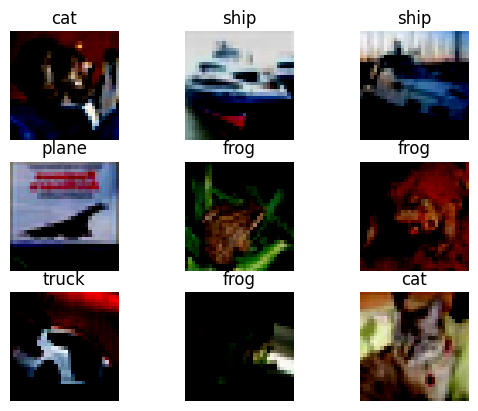

In [38]:
data, label = next(iter(test_dl))
data, label = data.to(DEVICE), F.one_hot(label, 10).float().to(DEVICE)

out = model(data)

fig, axs = plt.subplots(3, 3)

for i, im in enumerate(data.cpu().numpy()[:9]):
    ax = axs.flatten()[i]
    im = im.transpose()
    im = np.rot90(im, -1)
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(classes[out[i].argmax()])

plt.show()

# With aux

## Training loop

In [45]:
model = InceptionV3(10, True)

num_epochs = 15
file_label = 'inceptionv3-adam-15-cifar10-aux'

model = model.to(DEVICE)

if os.path.exists(f'{BASE_DIR}/checkpoints/savepoint-{file_label}.pt'):
    model.load_state_dict(torch.load(f'{BASE_DIR}/checkpoints/savepoint-{file_label}.pt'))
    history = torch.load(f'{BASE_DIR}/checkpoints/history-{file_label}.pt')
else:
    history = {
        'loss': [],
        'val_loss': []
    }

num_epochs_completed = len(history['loss'])

criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epochs_completed+1, num_epochs+1):
    with tqdm(train_dl, unit='batch') as tepoch:
        epoch_losses = []
        model.train()
        for data, target in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            data, target = data.to(DEVICE), F.one_hot(target, 10).float().to(DEVICE)
            optimizer.zero_grad()
            out, aux = model(data)
            loss1 = criterion(out, target)
            loss2 = criterion(aux, target)
            loss = loss1 + loss2
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            correct = (out.argmax(1) == target.argmax(1)).sum().item()
            accuracy = correct / len(target)

            tepoch.set_postfix(loss=loss.item(), accuracy=accuracy)
    epoch_mean_loss = sum(epoch_losses) / len(epoch_losses)
    history['loss'].append(epoch_mean_loss)

    with torch.no_grad():
        epoch_val_losses = []
        model.eval()
        for data, target in val_dl:
            data, target = data.to(DEVICE), F.one_hot(target, 10).float().to(DEVICE)
            out = model(data)
            loss = criterion(out, target)
            epoch_val_losses.append(loss.item())
        epoch_mean_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
        history['val_loss'].append(epoch_mean_val_loss)

    torch.save(model.state_dict(), f'{BASE_DIR}/checkpoints/savepoint-{file_label}.pt')
    torch.save(history, f'{BASE_DIR}/checkpoints/history-{file_label}.pt')

    print(f'done epoch {epoch} with results: loss={epoch_mean_loss}, val_loss={epoch_mean_val_loss}')

Epoch 1: 100%|██████████| 352/352 [00:44<00:00,  7.97batch/s, accuracy=0.569, loss=1.08] 


done epoch 1 with results: loss=1.4781630106947639, val_loss=1.349469056725502


Epoch 2: 100%|██████████| 352/352 [00:44<00:00,  7.98batch/s, accuracy=0.778, loss=0.592]


done epoch 2 with results: loss=0.9364015326242555, val_loss=0.7959494344890118


Epoch 3: 100%|██████████| 352/352 [00:44<00:00,  7.97batch/s, accuracy=0.778, loss=0.641]


done epoch 3 with results: loss=0.6960013956678185, val_loss=0.6884273201227188


Epoch 4: 100%|██████████| 352/352 [00:44<00:00,  7.97batch/s, accuracy=0.778, loss=0.618]


done epoch 4 with results: loss=0.5481660095128146, val_loss=0.5516543067991734


Epoch 5: 100%|██████████| 352/352 [00:44<00:00,  7.97batch/s, accuracy=0.833, loss=0.555]


done epoch 5 with results: loss=0.45967114928432484, val_loss=0.5407263182103634


Epoch 6: 100%|██████████| 352/352 [00:44<00:00,  7.96batch/s, accuracy=0.861, loss=0.433]


done epoch 6 with results: loss=0.394314582882957, val_loss=0.5352998107671738


Epoch 7: 100%|██████████| 352/352 [00:44<00:00,  7.95batch/s, accuracy=0.861, loss=0.374]


done epoch 7 with results: loss=0.33582073826850817, val_loss=0.520741568505764


Epoch 8: 100%|██████████| 352/352 [00:44<00:00,  7.97batch/s, accuracy=0.931, loss=0.22] 


done epoch 8 with results: loss=0.2903236377222294, val_loss=0.4497684741392732


Epoch 9: 100%|██████████| 352/352 [00:44<00:00,  7.99batch/s, accuracy=0.903, loss=0.344] 


done epoch 9 with results: loss=0.2460433557968248, val_loss=0.4711457617580891


Epoch 10: 100%|██████████| 352/352 [00:44<00:00,  7.97batch/s, accuracy=0.903, loss=0.265]


done epoch 10 with results: loss=0.2139908222862604, val_loss=0.5657155692577363


Epoch 11: 100%|██████████| 352/352 [00:44<00:00,  7.98batch/s, accuracy=0.917, loss=0.298] 


done epoch 11 with results: loss=0.18971802723932674, val_loss=0.45317627135664224


Epoch 12: 100%|██████████| 352/352 [00:44<00:00,  7.96batch/s, accuracy=0.931, loss=0.311] 


done epoch 12 with results: loss=0.15598480717744678, val_loss=0.4405971858650446


Epoch 13: 100%|██████████| 352/352 [00:44<00:00,  7.96batch/s, accuracy=0.931, loss=0.212] 


done epoch 13 with results: loss=0.1365756097419018, val_loss=0.48392593264579775


Epoch 14: 100%|██████████| 352/352 [00:44<00:00,  7.97batch/s, accuracy=0.972, loss=0.142] 


done epoch 14 with results: loss=0.12395563152280044, val_loss=0.4918086614459753


Epoch 15: 100%|██████████| 352/352 [00:44<00:00,  7.97batch/s, accuracy=0.972, loss=0.0632]


done epoch 15 with results: loss=0.1090063030238856, val_loss=0.487869318574667


## History

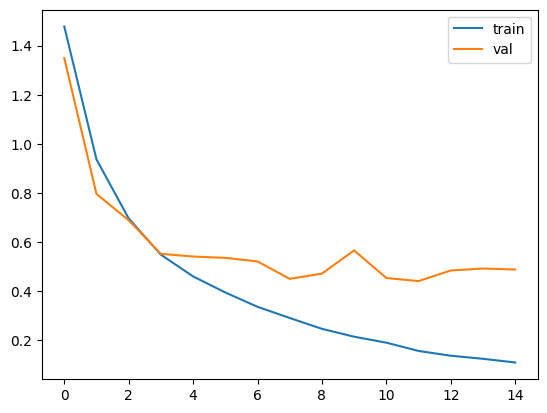

In [46]:
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')

plt.legend()

plt.show()

## Metrics

In [47]:
test_losses = []
test_acc = []
with torch.no_grad():
    model = model.eval()
    for data, label in test_dl:
        data, label = data.to(DEVICE), F.one_hot(label, 10).float().to(DEVICE)
        out = model(data)

        loss = criterion(out, label)
        test_losses.append(loss.item())

        correct = (out.argmax(1) == label.argmax(1)).sum().item()
        accuracy = correct / len(label)
        test_acc.append(accuracy)

sum(test_losses) / len(test_losses), sum(test_acc) / len(test_acc)

(0.5442129958279526, 0.8609572784810127)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


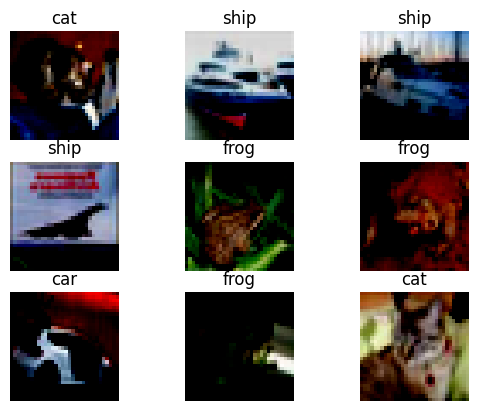

In [48]:
data, label = next(iter(test_dl))
data, label = data.to(DEVICE), F.one_hot(label, 10).float().to(DEVICE)

out = model(data)

fig, axs = plt.subplots(3, 3)

for i, im in enumerate(data.cpu().numpy()[:9]):
    ax = axs.flatten()[i]
    im = im.transpose()
    im = np.rot90(im, -1)
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(classes[out[i].argmax()])

plt.show()